# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [34]:
%matplotlib inline 
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.io import loadmat

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat('data/train_32x32.mat')
testset = loadmat('data/test_32x32.mat')

In [5]:
type(trainset)

dict

In [6]:
trainset['X'][0]

array([[[ 33,  84,  19, ...,  92, 190, 216],
        [ 30,  76,  54, ...,  78, 188, 217],
        [ 38,  59, 110, ..., 101, 191, 212]],

       [[ 15,  86,  20, ...,  94, 205, 221],
        [ 23,  73,  52, ...,  82, 203, 222],
        [ 19,  66, 111, ..., 105, 206, 217]],

       [[ 15,  77,  25, ..., 114, 220, 226],
        [ 17,  78,  57, ..., 101, 218, 227],
        [ 19,  56, 116, ..., 125, 220, 221]],

       ...,

       [[ 72,  90,  65, ..., 200, 229, 200],
        [ 65,  78, 144, ..., 201, 231, 199],
        [ 56,  69, 223, ..., 203, 224, 191]],

       [[ 82,  88,  78, ..., 192, 229, 193],
        [ 77,  77, 148, ..., 193, 229, 188],
        [ 57,  67, 218, ..., 195, 224, 182]],

       [[ 89,  88,  98, ..., 190, 229, 197],
        [ 79,  78, 158, ..., 191, 228, 189],
        [ 59,  66, 220, ..., 193, 223, 186]]], dtype=uint8)

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

In [7]:
trainset['X'].shape, testset['X'].shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [8]:
trainset['y'].shape, testset['y'].shape

((73257, 1), (26032, 1))

In [9]:
len(testset['y']), testset['y'].shape[0]

(26032, 26032)

In [10]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
idx

array([12636,  5932, 70358, 61878, 23394, 72182, 68308, 46120, 53938,
       45262,  8936, 44410, 62518, 55732, 47680, 23255, 22786, 46132,
       30371, 70222, 49724, 35612, 67725, 44665, 67785, 27722, 30432,
       28401, 19866, 24822, 42493, 29471,  1525, 30993, 31470, 51210])

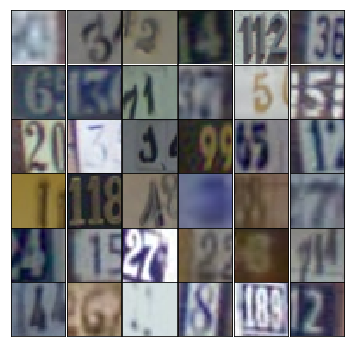

In [11]:
fig, axes = plt.subplots(6, 6, figsize=(6,6))
for i, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [12]:
def scale(x, feature_range=(-1,1)):
    # pixels are between 0 and 255, so we first bring them to the range 0 to 1
    xmin = x.min()
    x = (x - xmin)/(255 - xmin)
    
    fmin, fmax = feature_range
    x = x * (fmax - fmin) + fmin
    return x

In [13]:
class Dataset:
    def __init__(self, train, test, val_frac=.5, shuffle=False, scale_func=None):
        
        self.train_x, self.train_y = train['X'], train['y']
        
        split_indx = int(test['y'].shape[0] * (1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_indx], test['X'][:,:,:,split_indx:]
        self.test_y, self.valid_y = test['y'][:split_indx], test['y'][split_indx:]
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
            
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        n_batches = len(self.train_y)//batch_size
        for i in range(0, len(self.train_y), batch_size):
            x = self.train_x[i:i+batch_size]
            y = self.train_y[i:i+batch_size]
            
            yield self.scaler(x),y

## Network Inputs

Here, just creating some placeholders like normal.

In [14]:
def model_inputs(real_dim, z_dim):
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return input_real, input_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

### **Note:** Strides define the impact on height and width, filters define the feature len

In [15]:
def generator(z, output_dim, reuse=False, alpha=.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # x1 shape => (4x4x512)

        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 shape => (8x8x256)

        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 shape => (16x16x128)

        logits = tf.layers.conv2d_transpose(x3, filters=output_dim, kernel_size=5, strides=2, padding='same')
        # logits shape => (32x32x3)

        out = tf.tanh(logits)

        return out
    

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [16]:
def discriminator(x, reuse=False, alpha=.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # input => 32x32x3
        x1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # x1 => 16x16x64
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 => 8x8x128
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 => 4x4x256

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [17]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss 

In [18]:
# def model_loss(input_real, input_z, output_dim, alpha=0.2):
#     """
#     Get the loss for the discriminator and generator
#     :param input_real: Images from the real dataset
#     :param input_z: Z input
#     :param out_channel_dim: The number of channels in the output image
#     :return: A tuple of (discriminator loss, generator loss)
#     """
#     g_model = generator(input_z, output_dim, alpha=alpha)
#     d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
#     d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
#     g_loss = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

#     d_loss = d_loss_real + d_loss_fake

#     return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    g_vars = [x for x in t_vars if x.name.startswith('generator')]
    d_vars = [x for x in t_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [20]:
class GAN:
    def __init__(self, real_dim, z_dim, learning_rate, alpha=.2, beta1=.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_dim, z_dim)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_dim[2],alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        

Here is a function for displaying generated images.

In [26]:
def view_samples(epoch, samples, rows, cols, figsize=(5,5)):
    
    fig, axes = plt.subplots(figsize=figsize, nrows=rows, ncols=cols, sharex=True, sharey=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        ax.imshow(img, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [27]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    samples = []
    losses = []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real:x, net.input_z:batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_real:x, net.input_z:batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [31]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.002
batch_size = 64
epochs = 2
alpha = 0.1
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [32]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)


Epoch 1/2... Discriminator Loss: 0.2029... Generator Loss: 14.4892
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 2.7808
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.5839
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.4153
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.2818
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 1.2275
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.0824


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


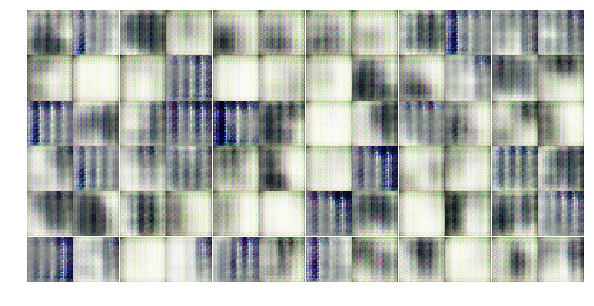

Epoch 1/2... Discriminator Loss: 1.8714... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 1.4766
Epoch 1/2... Discriminator Loss: 1.7302... Generator Loss: 0.2405
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 0.8691... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 1.6301... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 2.5120
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.4989


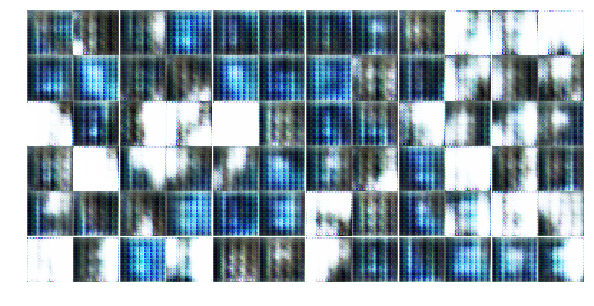

Epoch 1/2... Discriminator Loss: 0.3100... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 1.5371... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.9676
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.8891
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.7779... Generator Loss: 0.3752
Epoch 1/2... Discriminator Loss: 2.0089... Generator Loss: 2.0310


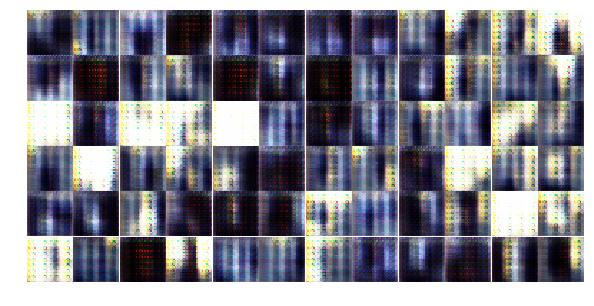

Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 1.4440
Epoch 1/2... Discriminator Loss: 0.4284... Generator Loss: 1.8557
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 2.3669
Epoch 1/2... Discriminator Loss: 1.8326... Generator Loss: 0.3330
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 2.0536
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 0.5673... Generator Loss: 1.6195


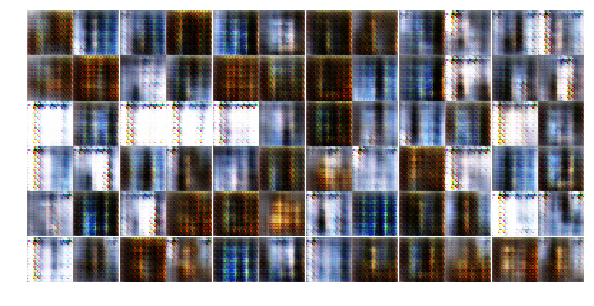

Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.1901
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 1.5882
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 1.9328... Generator Loss: 0.2588
Epoch 1/2... Discriminator Loss: 1.9578... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 1.1954


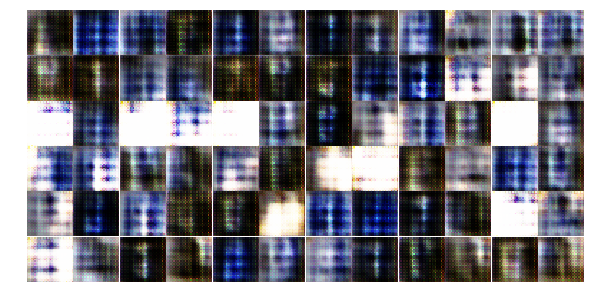

Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 1.3440
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.4549
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.5719


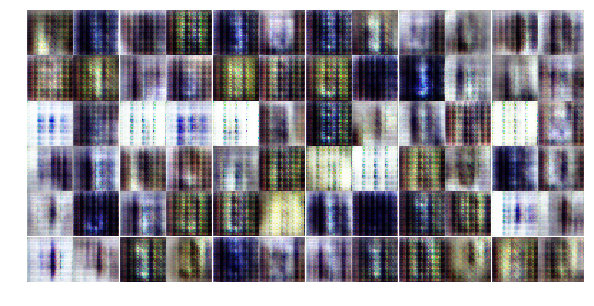

Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.5945... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.6123
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 1.0483
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.6853


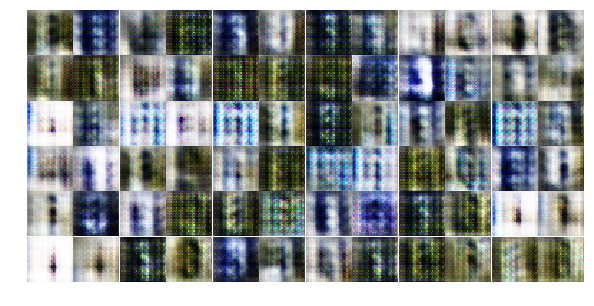

Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.9573


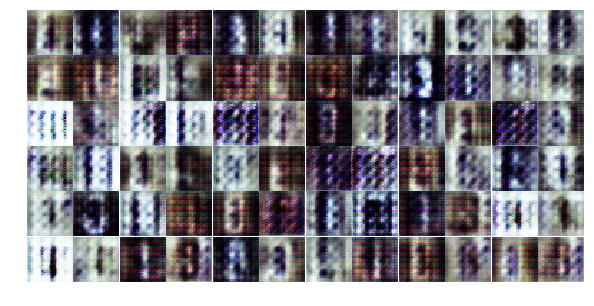

Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 0.9227
Epoch 1/2... Discriminator Loss: 1.6655... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.9159... Generator Loss: 0.2233
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 1.0326


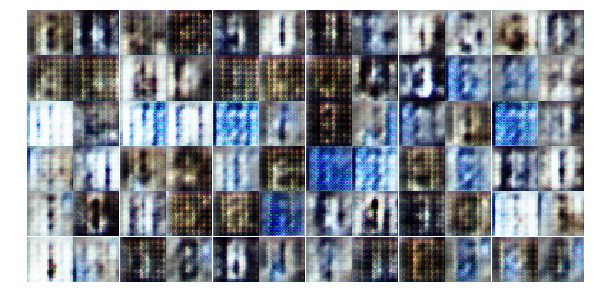

Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 1.7536... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.4828


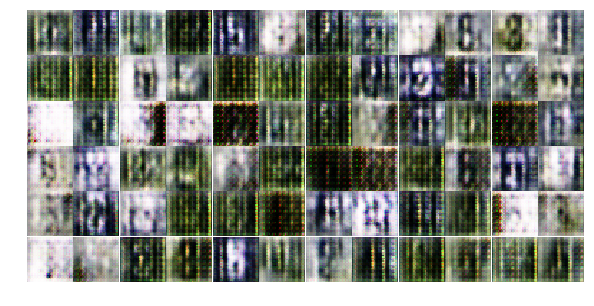

Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.9943
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.6582


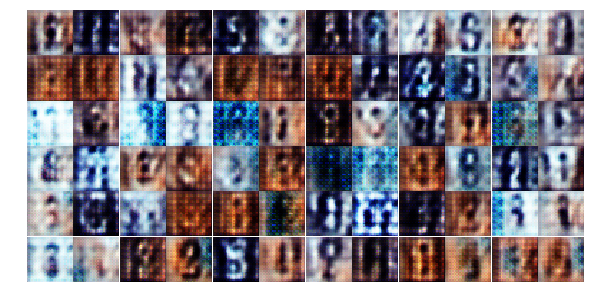

Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 1.6047
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.5257... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 1.2571
Epoch 2/2... Discriminator Loss: 1.7692... Generator Loss: 0.2538
Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 0.6696


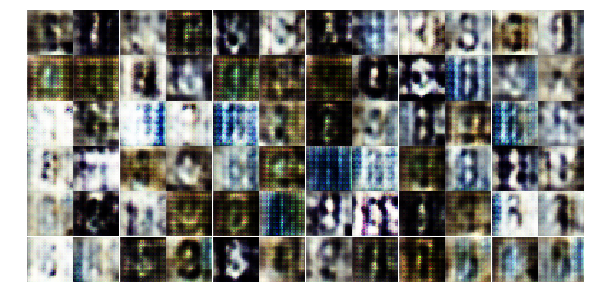

Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.2525
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 1.0108
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 1.5972... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.7472


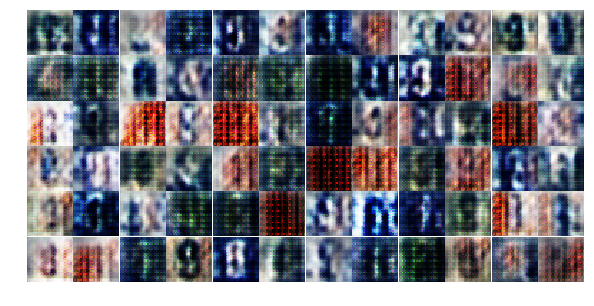

Epoch 2/2... Discriminator Loss: 2.0152... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.5267... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.5395... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.9087


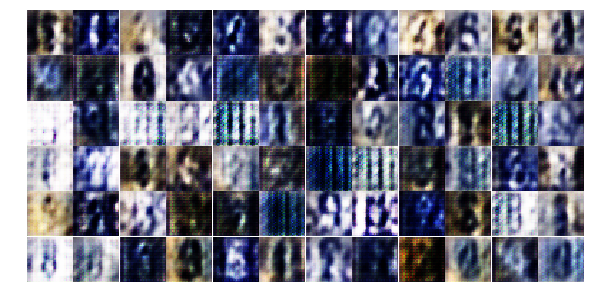

Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.1567... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.8837
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.8563
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.7025... Generator Loss: 0.3803
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.6137


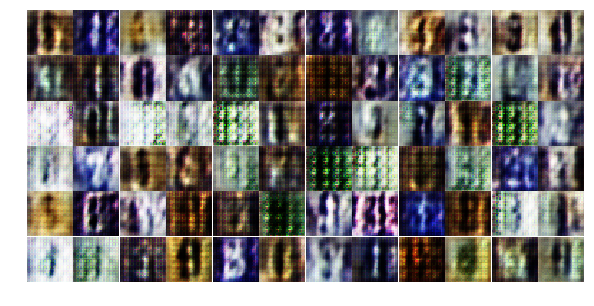

Epoch 2/2... Discriminator Loss: 1.2115... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.6104
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.6170
Epoch 2/2... Discriminator Loss: 1.1268... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.6870


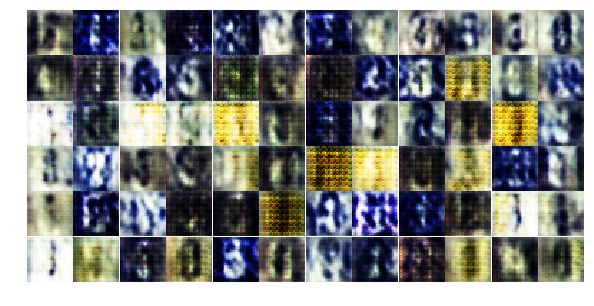

Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.5820... Generator Loss: 0.5231
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 1.4611... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.5579


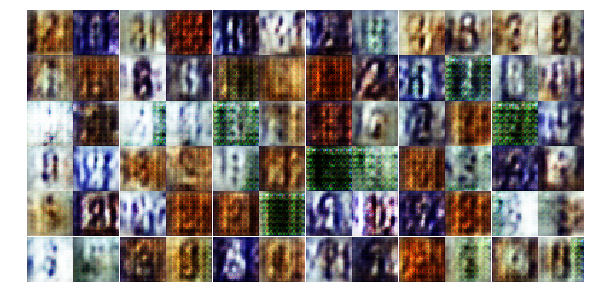

Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.0994... Generator Loss: 0.7710
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 1.4796
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 1.2330


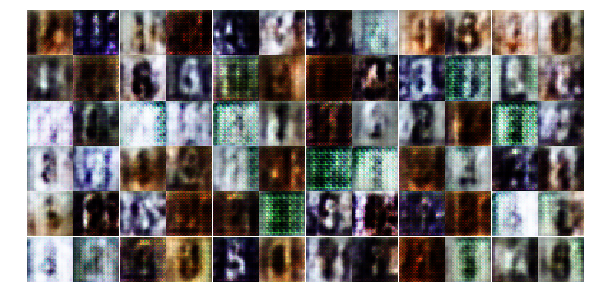

Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.1209... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.6769


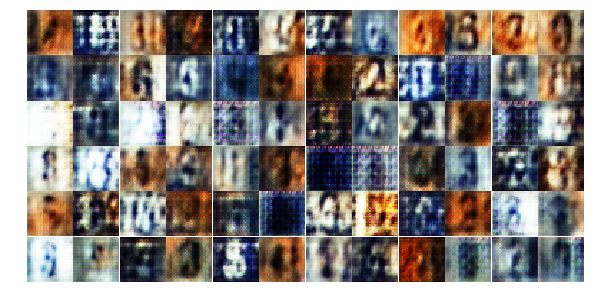

Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.4611
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.9075
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.7966


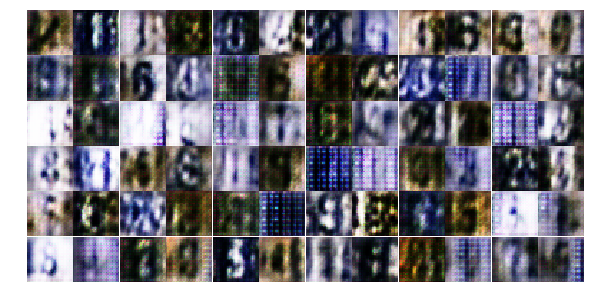

Epoch 2/2... Discriminator Loss: 1.2908... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 1.0841... Generator Loss: 1.1706
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.0116
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6481
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 1.3755... Generator Loss: 0.4551


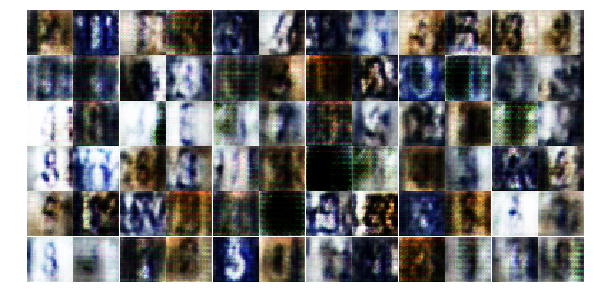

Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 1.4767... Generator Loss: 0.4150
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 0.5876
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.5490
Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.4026


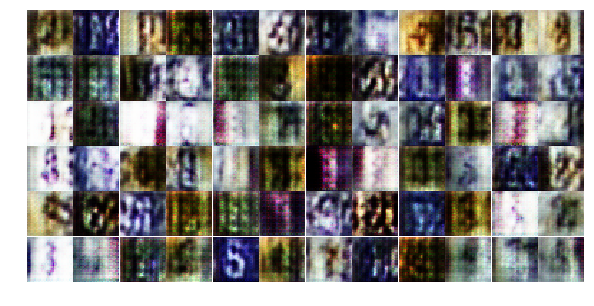

Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.7391
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.5639
Epoch 2/2... Discriminator Loss: 1.7803... Generator Loss: 0.2676
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 1.1104
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9380


In [35]:
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

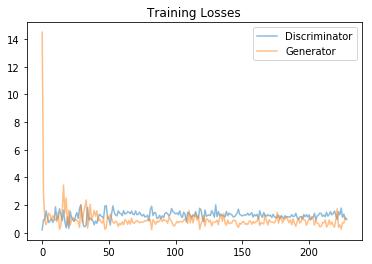

In [36]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


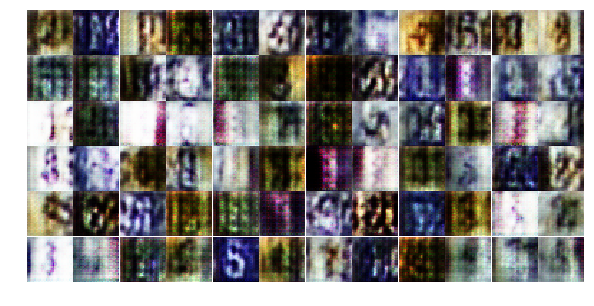

In [37]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))